### Predictive Maintenance Using Machine Parameters
This program takes a 14 dimensional file consisting of 10,000 synthetic datapoints which simulate data collected from a machine
* Identifiers (2): UID, Product ID
* Input parameters (6): Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min]
* Response (1): Machine failure
* Failure modes (5): TWF (Tool Wear Failure), HDF (Heat Dissipation Failure), PWF (Power Failure), OSF (Overstrain Failure), RNF (Random Failures)

## 1. Import and summarize the data

In [1]:
import pandas as pd
import numpy as np

from time import time
from memory_profiler import memory_usage
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns  

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from plotnine import ggplot, aes, geom_boxplot, geom_text, facet_wrap, labs, theme, element_text, position_dodge, geom_bar, scale_fill_manual

# Load the predictive maintenance dataset and save it into a dataframe
machine_df = pd.read_csv('ai4i2020.csv')
machine_df = machine_df.drop(['UDI','Product ID'], axis=1)
target_names = ['Fail', 'Pass']

# Display summary statistics for exploratory data analysis
display(machine_df.head())
display(machine_df.describe())
display(machine_df.info())

# Display machine failure counts to check for representation
failure_counts_df = machine_df['Machine failure'].value_counts().reset_index()
failure_counts_df.columns = ['Machine failure', 'Count']
display(failure_counts_df)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


None

,Machine failure,Count
0,0,9661
1,1,339


## 2. Clean the data

In [2]:
# Clean the data

machine_df['Machine failure'] = machine_df['Machine failure'].map({0: 'Pass', 1: 'Fail'})  # Map 0 to Pass and 1 to Fail

# Optional: filter outliers (code will not run by default)

print("Original DataFrame size:", machine_df.shape)

# Function to remove outliers based on the IQR method for a given column
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply the function to each numeric column - change to True to filter
if False:
    for column in machine_df.select_dtypes(include='number').columns:
        machine_df = remove_outliers(machine_df, column)

print("Filtered DataFrame size:", machine_df.shape)

Original DataFrame size: (10000, 12)
Filtered DataFrame size: (10000, 12)


## 3. Visualize the data
### 3.1 Box plots of all continuous input variables against the response
* Check if there is any obvious delta in mean values between pass and fail

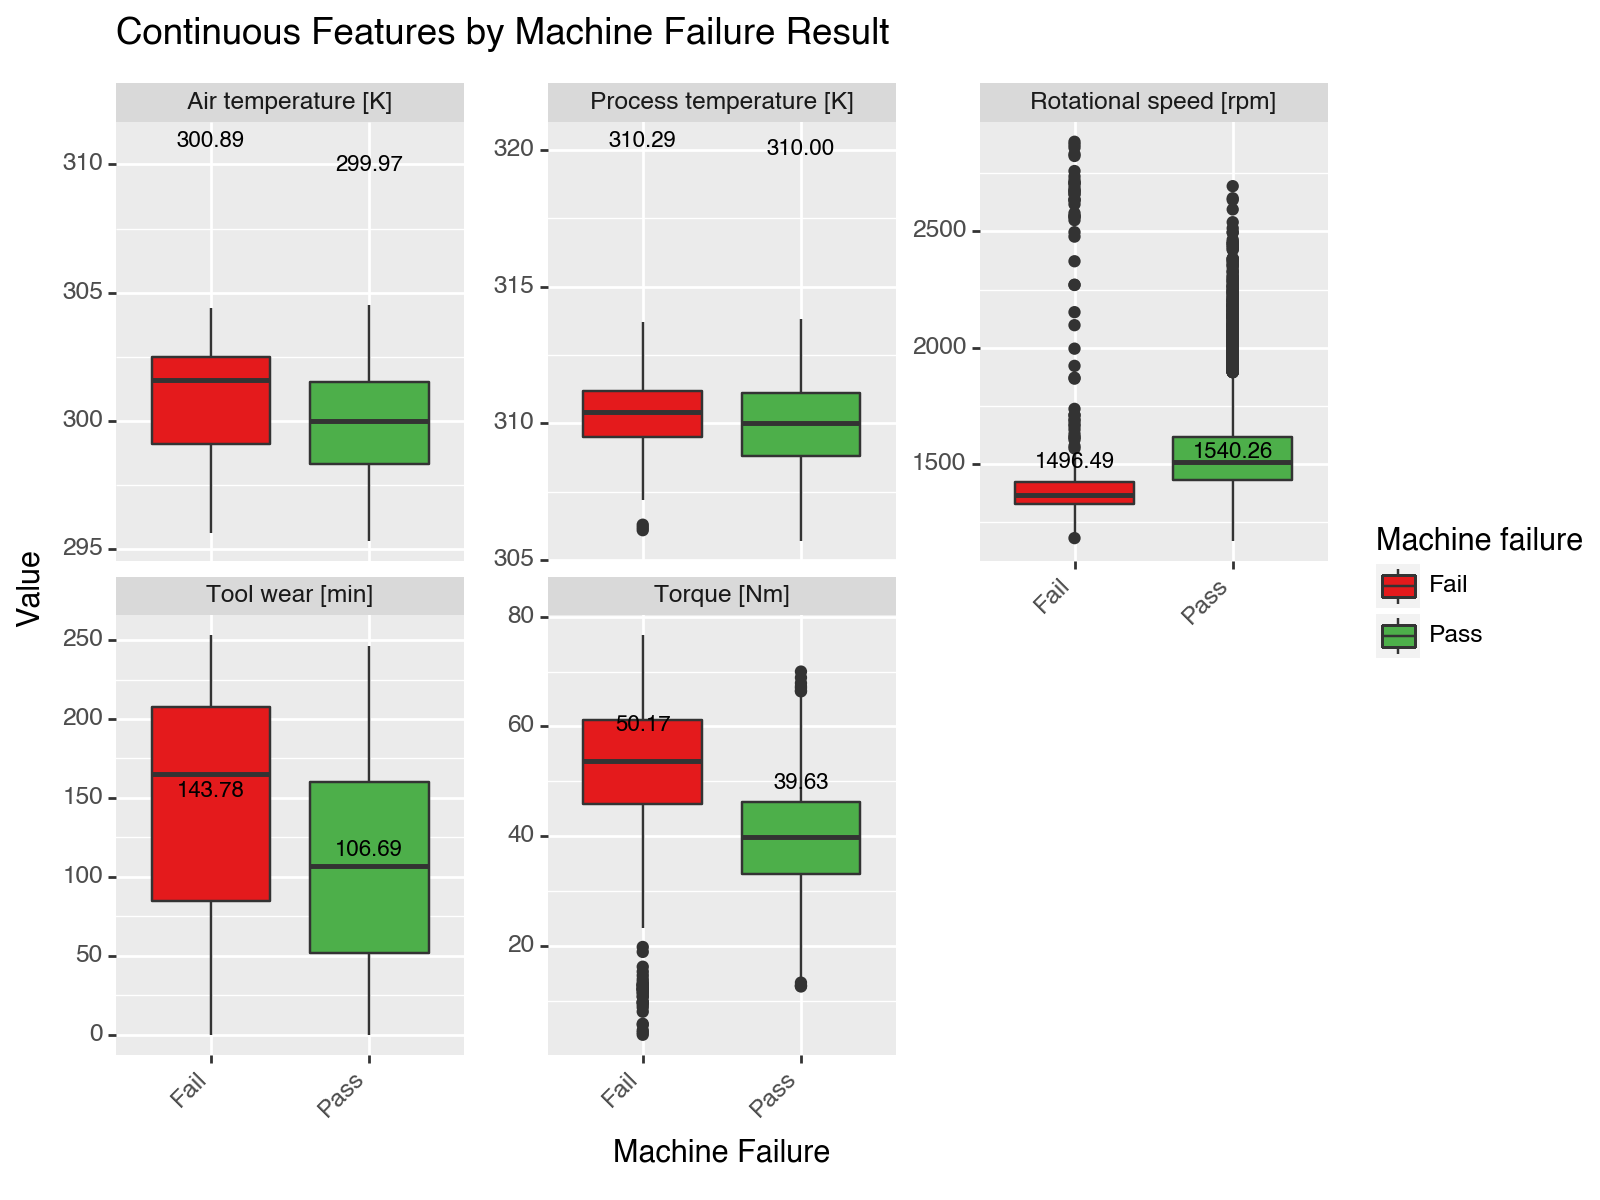

<Figure Size: (800 x 600)>

In [3]:
# Visualize all x variables with box plots

# Convert the DataFrame to a long format suitable for plotting
columns_to_plot = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']
filtered_df = machine_df[columns_to_plot]
machine_long_df = filtered_df.melt(id_vars="Machine failure", var_name="feature", value_name="value")

# Calculate means for each combination of feature and species
mean_values = machine_long_df.groupby(['feature', 'Machine failure'], observed=True)['value'].mean().reset_index()
mean_values['value_str'] = mean_values['value'].apply(lambda x: f'{x:.2f}')

# Create the plot with boxplot and mean values annotated, grouping by feature
plot = (
    ggplot(machine_long_df, aes(x='Machine failure', y='value', fill='Machine failure')) +
    geom_boxplot() +
    geom_text(data=mean_values, mapping=aes(x='Machine failure', y='value', label='value_str'),
              position=position_dodge(width=0.75), nudge_y=10, size=8, ha='center') + 
    facet_wrap('~ feature', scales='free_y') +
    labs(title='Continuous Features by Machine Failure Result', x='Machine Failure', y='Value') +
    theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6)) +
    scale_fill_manual(values={'Pass': '#4DAF4A', 'Fail': '#E41A1C'})
)

display(plot)

### 3.1 Type and class distribution
* Plot product types (S/M/L) and classes (pass/fail) in a stacked bar chart

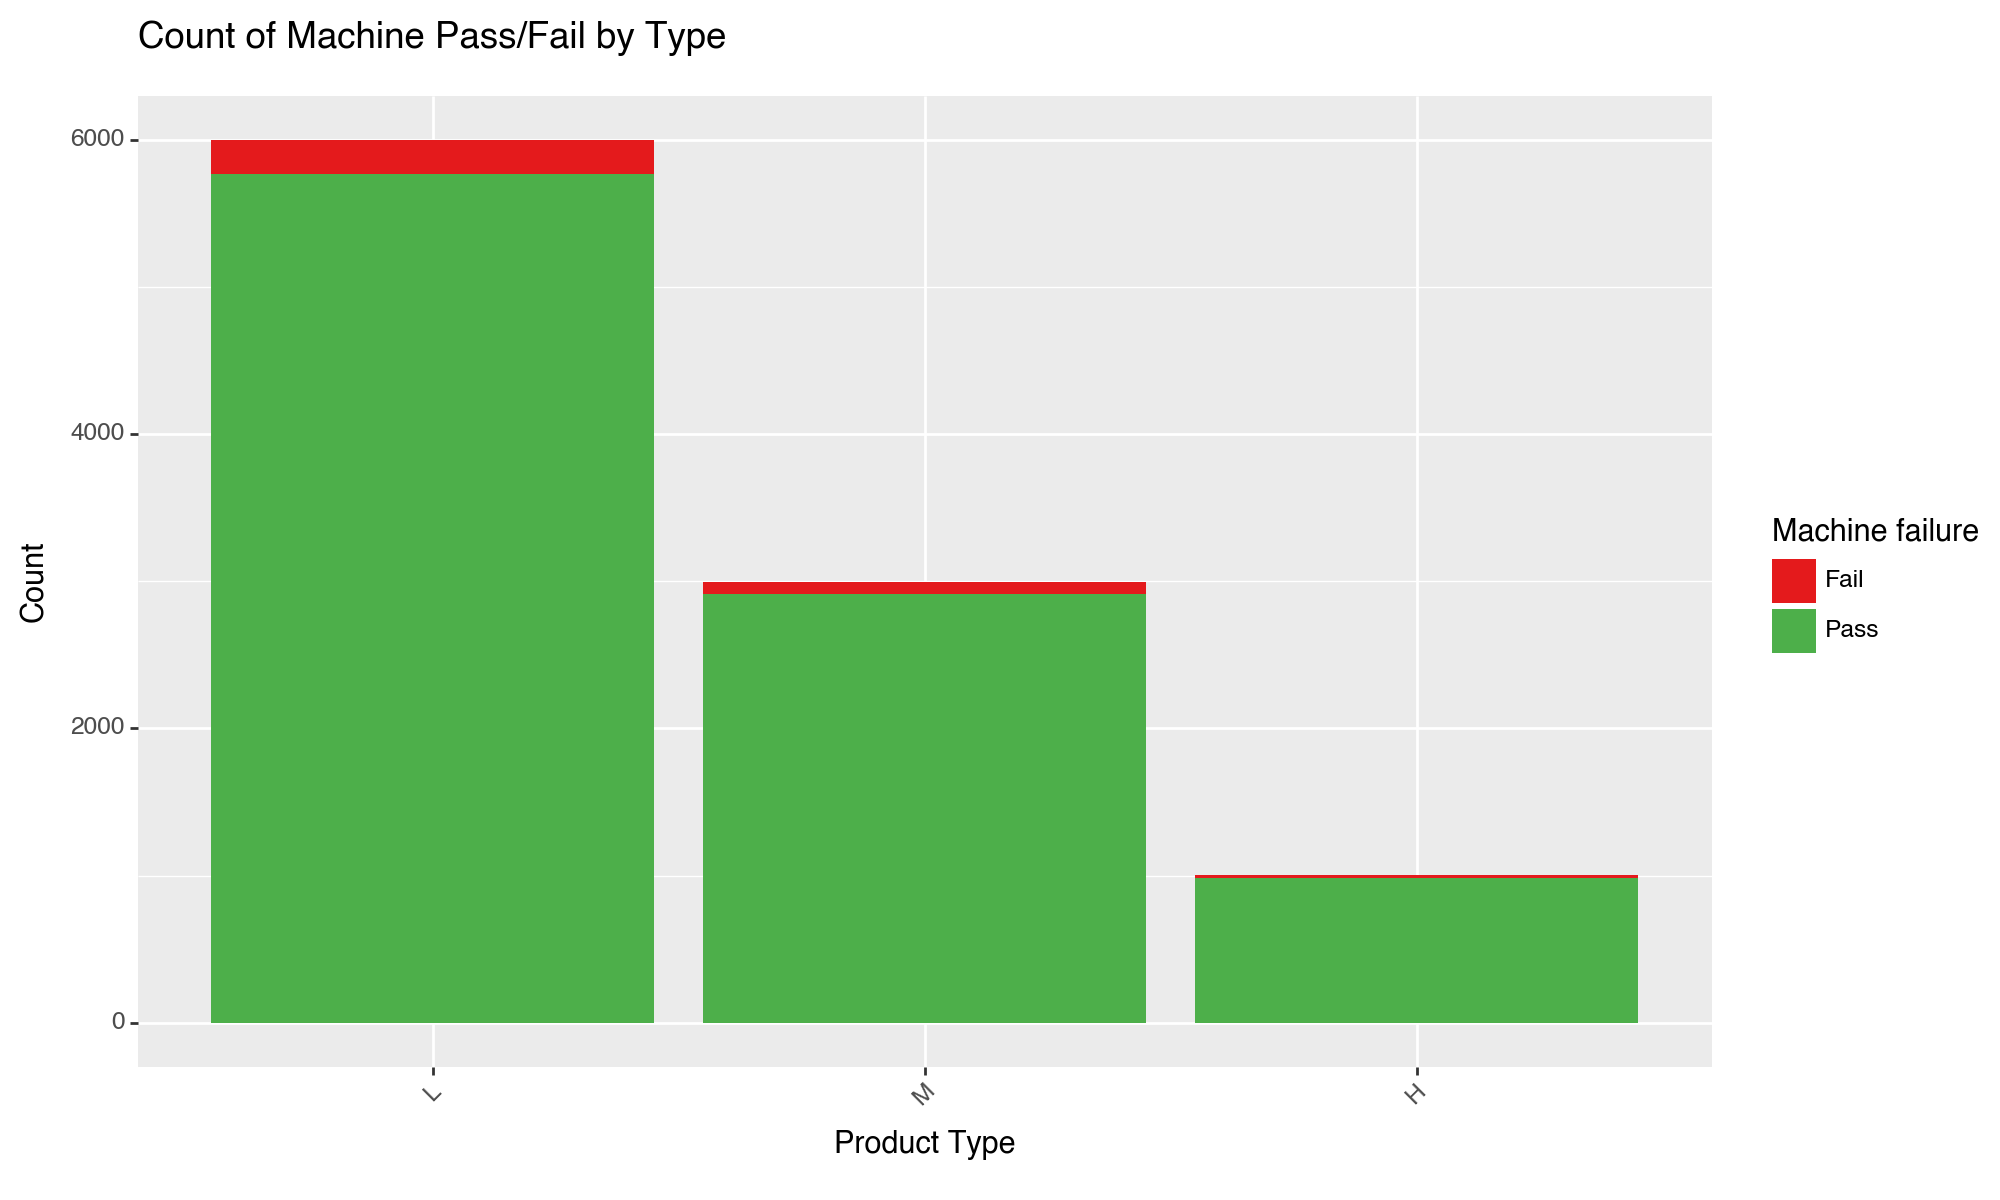

<Figure Size: (1000 x 600)>

In [4]:
df = machine_df.copy()
df['Type'] = pd.Categorical(df['Type'], categories=['L', 'M', 'H'], ordered=True)

plot = (
     ggplot(df) +
     aes(x='Type', fill='Machine failure') +
     geom_bar(position='stack') +
     labs(title='Count of Machine Pass/Fail by Type', x='Product Type', y='Count') +
     theme(axis_text_x=element_text(angle=45), figure_size=(10, 6)) +
     scale_fill_manual(values={'Pass': '#4DAF4A', 'Fail': '#E41A1C'})

)
display(plot)


## 4. Pre-process the data

In [5]:
## Create input features X and drop responses from it
X = machine_df.copy()
X = X.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)

# Map categorical features to numeric values
mapping = {'L': 1, 'M': 2, 'H': 3}
X['Type'] = X['Type'].map(mapping)

# Create response variable y
y = machine_df['Machine failure']

## Split the data into training and validation sets

# random_state: prng seed, changing this may change accuracy results
# stratify: ensure there are equal proportions of classes in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y) 

## Normalize x_train and x_test on continuous variables only

features_to_scale = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Create the ColumnTransformer with StandardScaler for the selected columns
# and "passthrough" for the rest
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale)
    ],
    remainder='passthrough'  # Leave the other features unchanged
)

# Fit on the training data and transform both training and test data
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

## Check pre-processing results

# Check the first values of X and y
display(X.head())
display(y.head())

# Check for missing, negative, and string values in X
display(X.isnull().any())
display((X < 0).any())
display(X.dtypes)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,2,298.1,308.6,1551,42.8,0
1,1,298.2,308.7,1408,46.3,3
2,1,298.1,308.5,1498,49.4,5
3,1,298.2,308.6,1433,39.5,7
4,1,298.2,308.7,1408,40.0,9


0    Pass
1    Pass
2    Pass
3    Pass
4    Pass
Name: Machine failure, dtype: object

Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
dtype: bool

Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
dtype: bool

Type                         int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
dtype: object

## 5. Feature Selection
### 5.1 Analyze correlation between input variables using a correlation matrix

Findings:
* Air and process temperatures are correlated
* Rotational speed is inversely correlated to torque

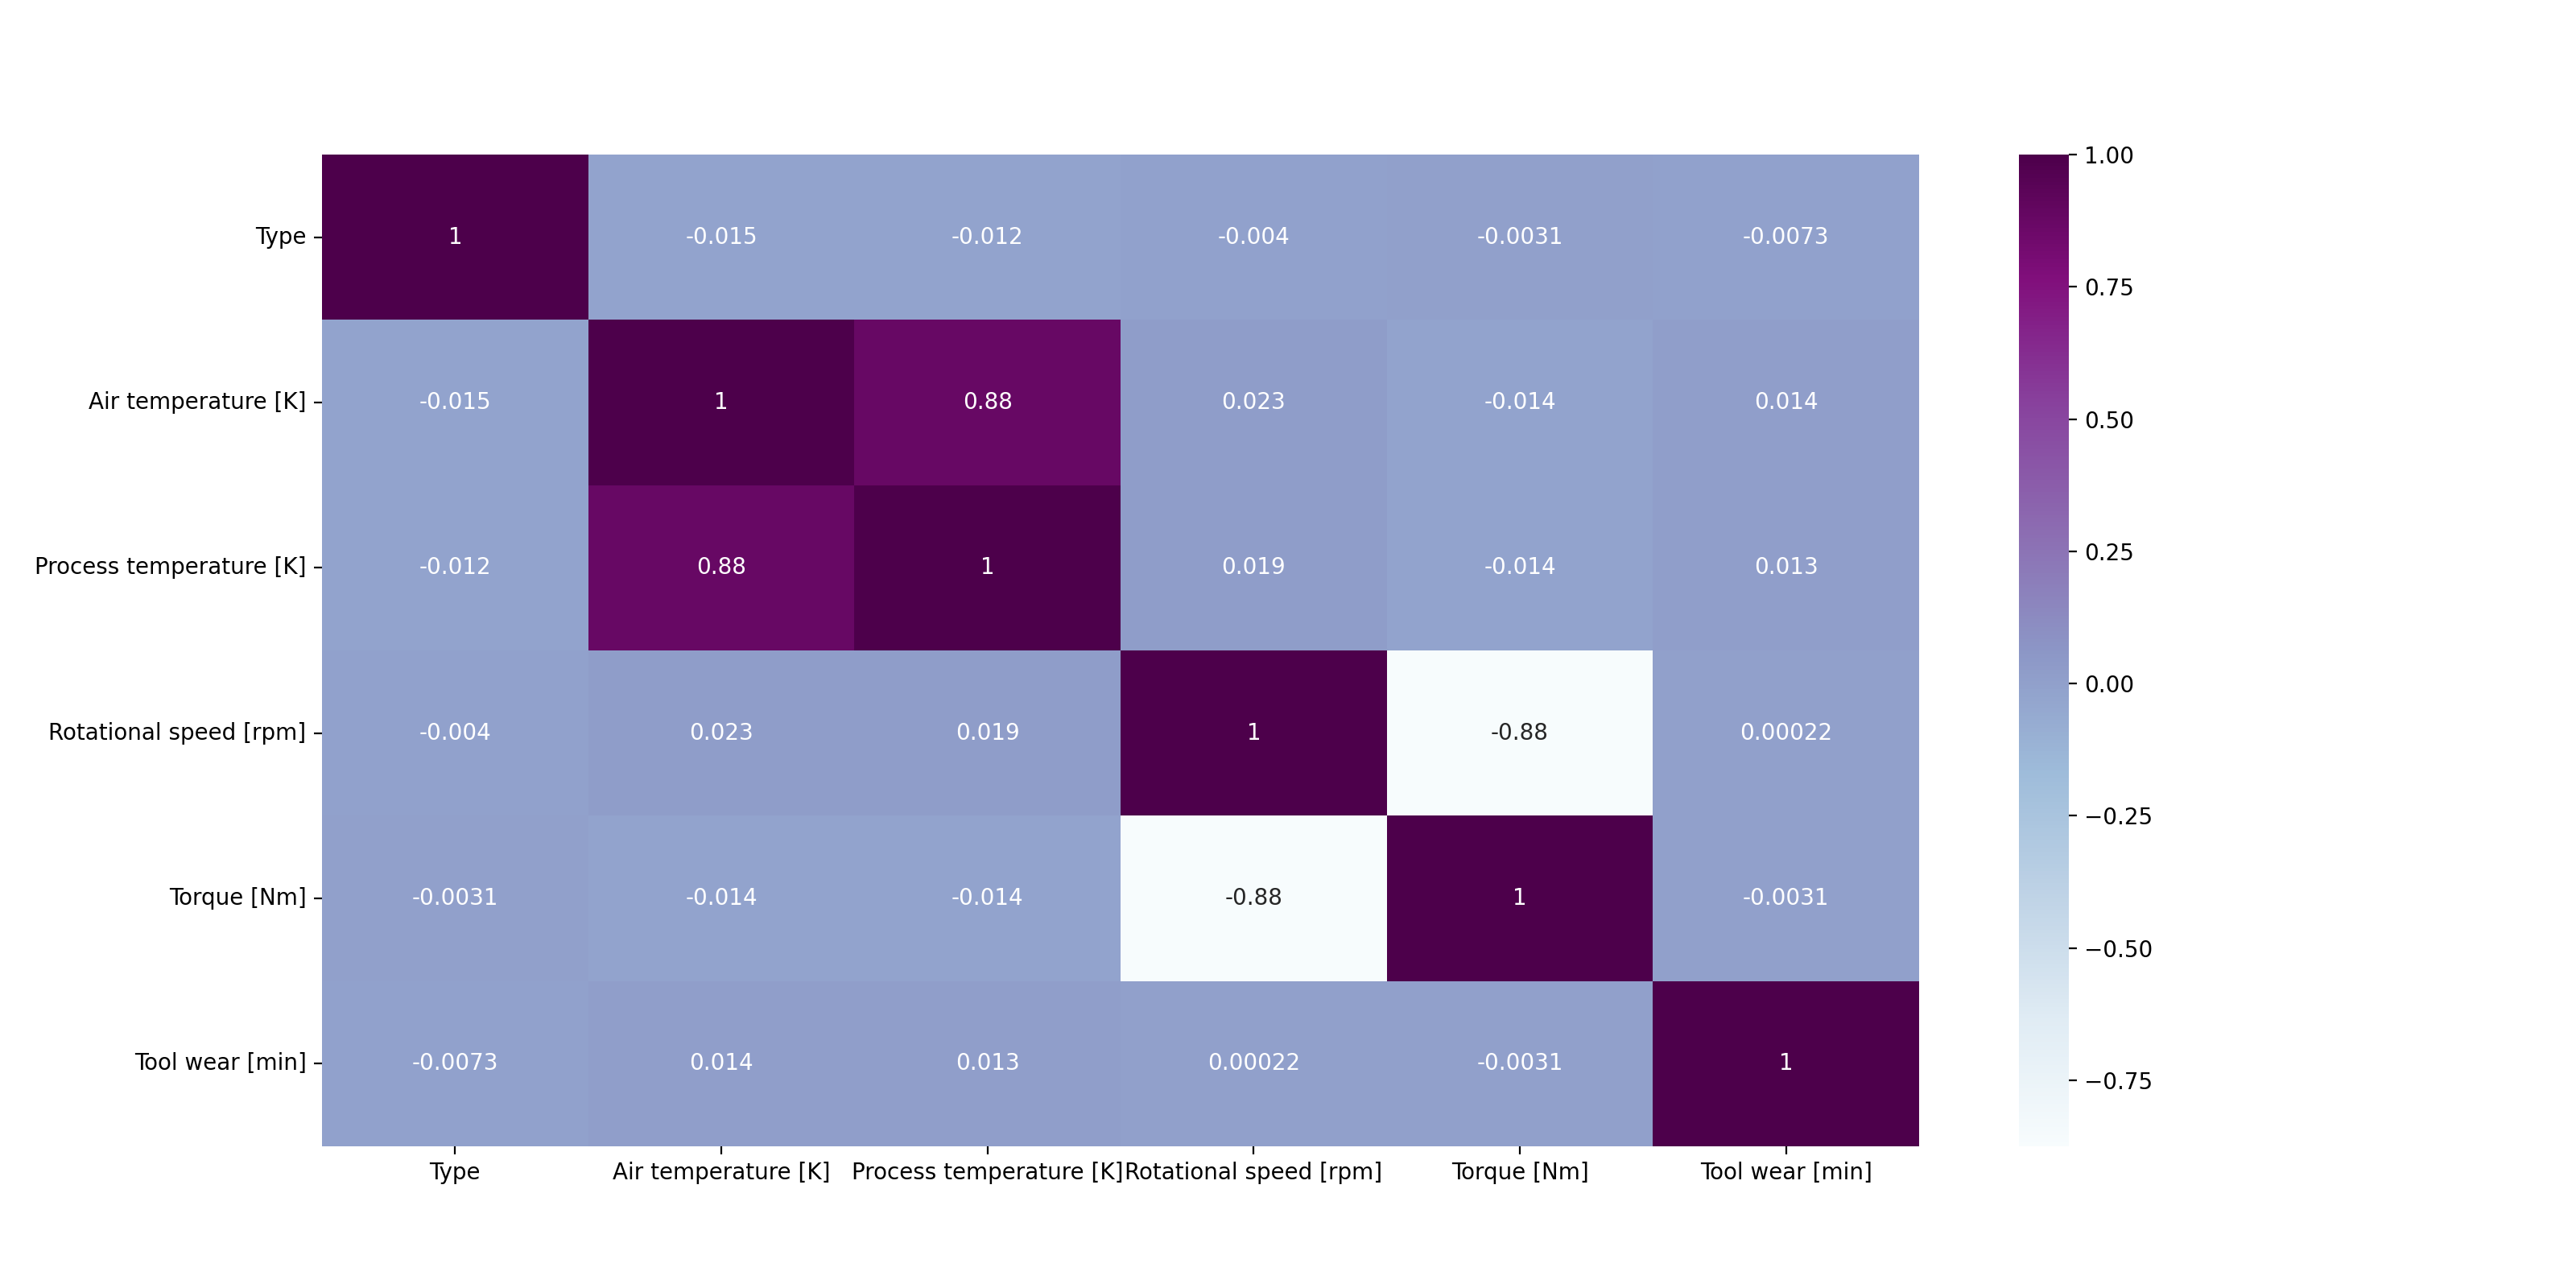

In [6]:
corr = X.corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr, annot = True, cmap="BuPu")
plt.show()

### 5.2 Analyze correlation between the input variables and response

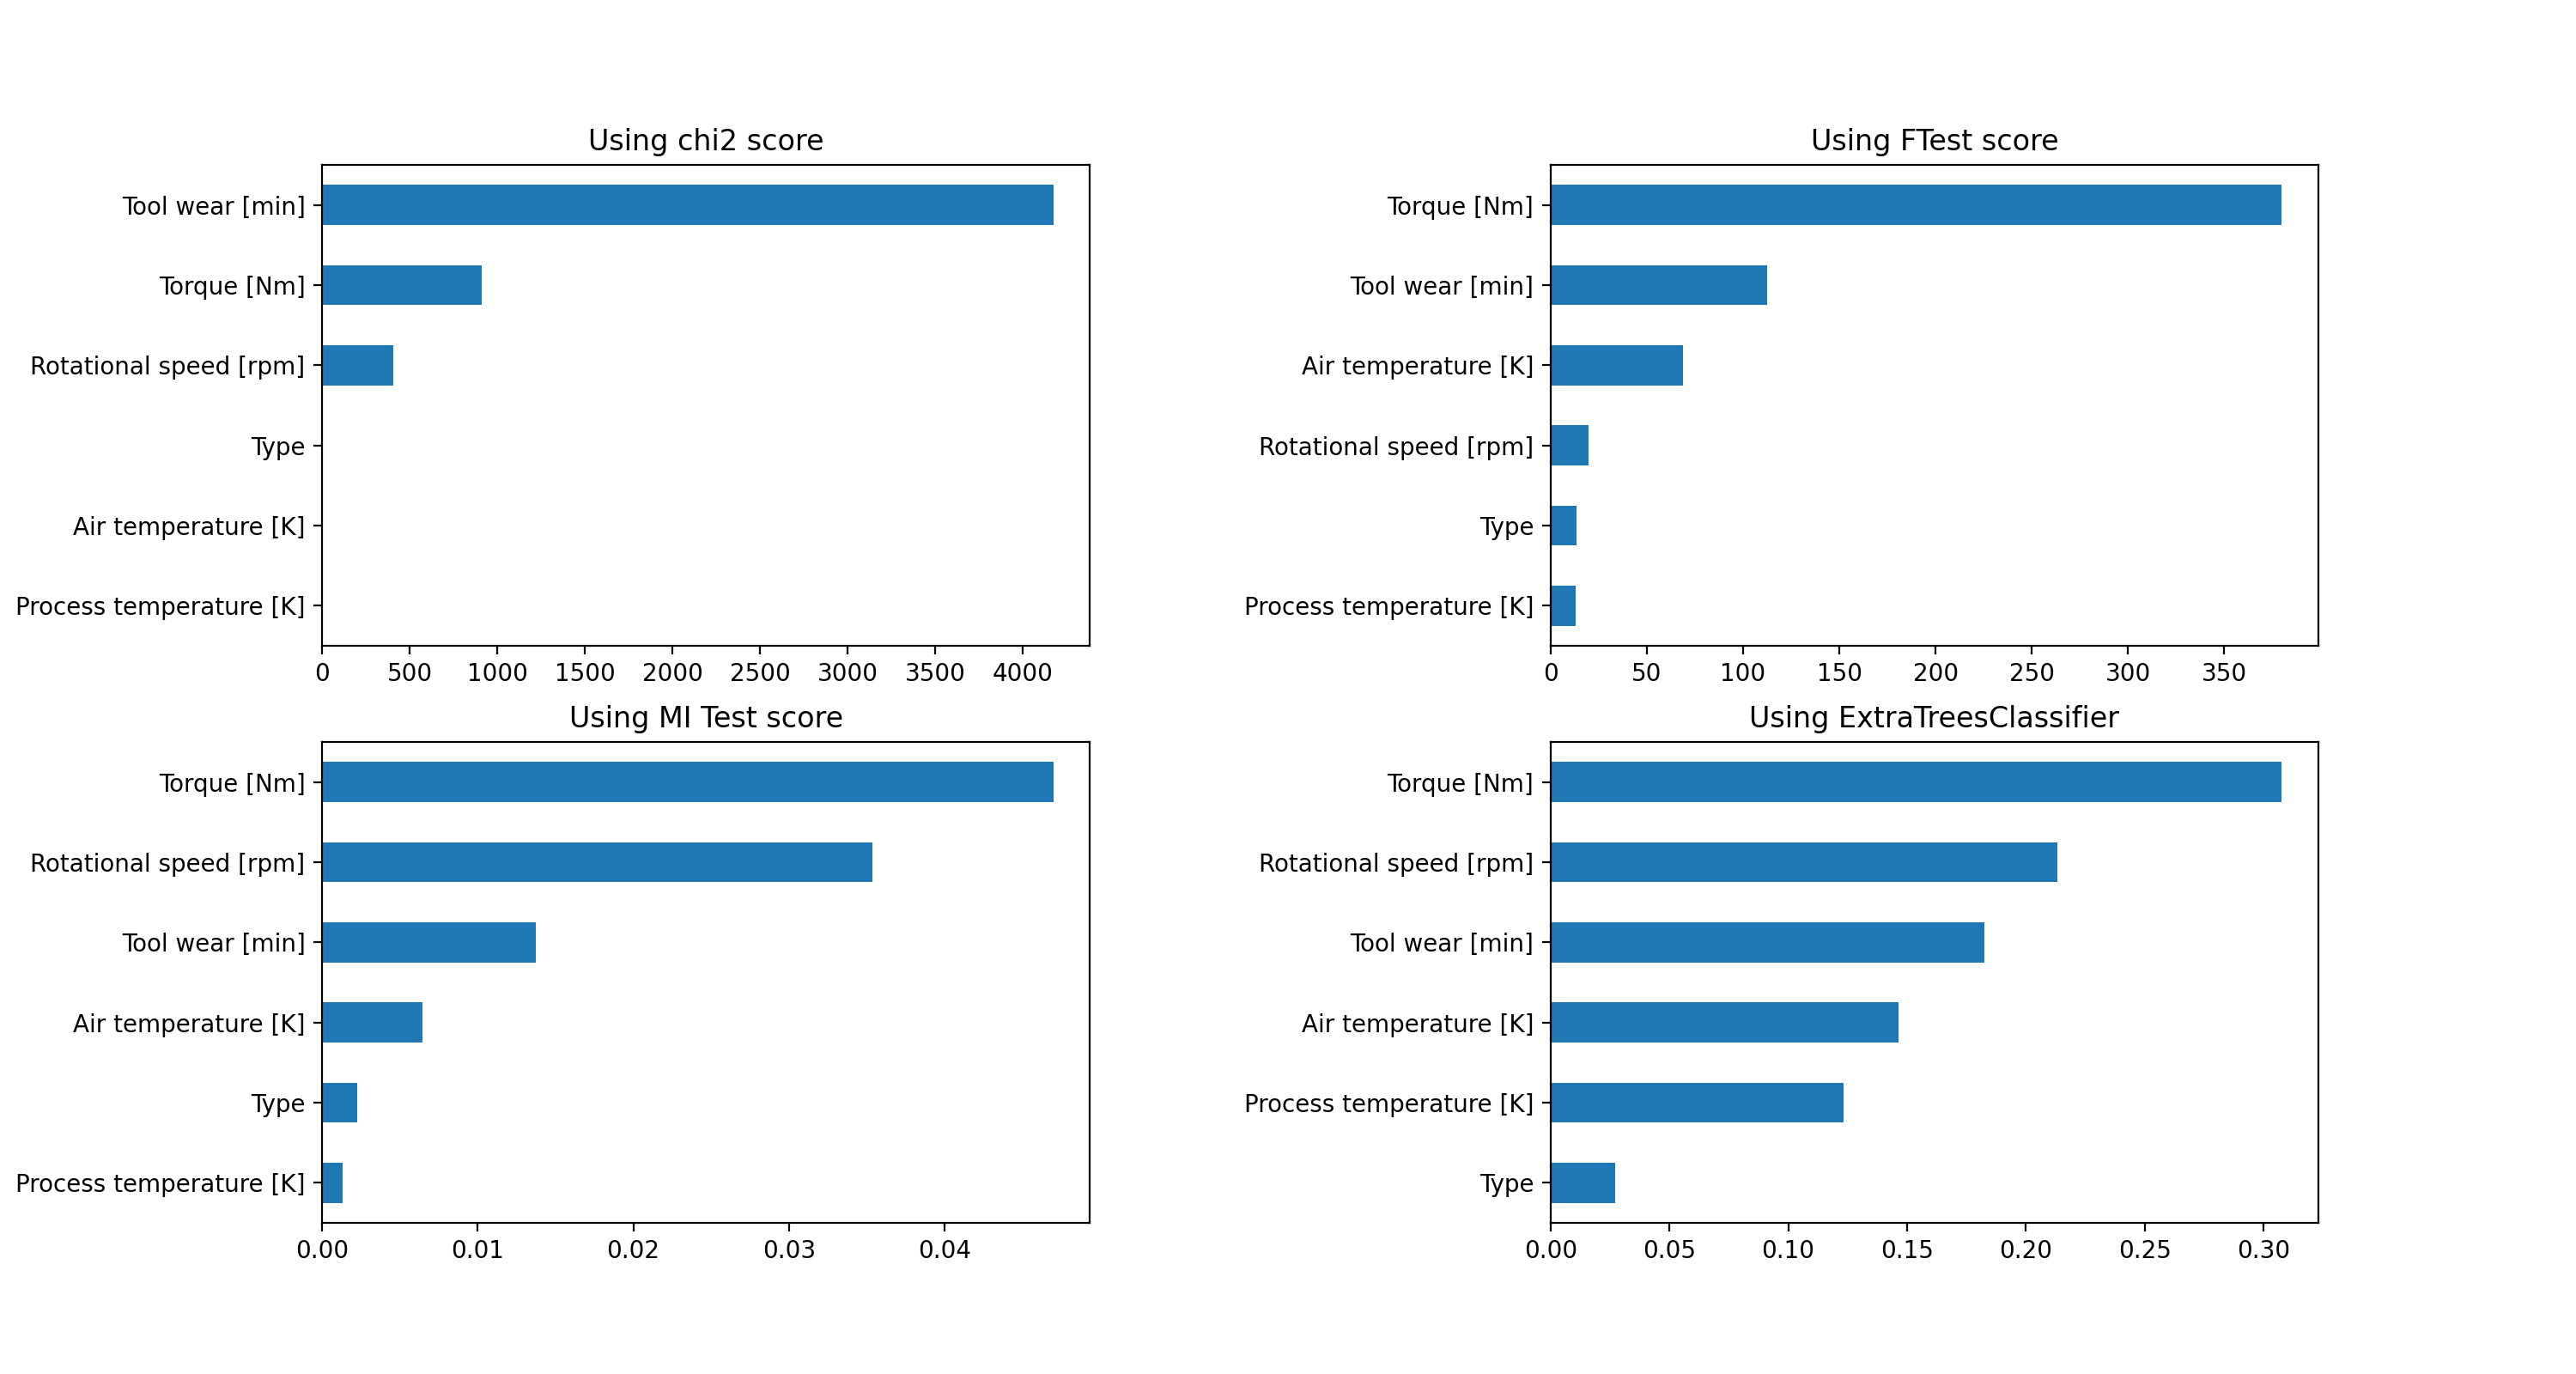

In [7]:
# Call the k-best method with Chi-squared score and pass X and y as inputs, then sort for plotting

chi2 = SelectKBest(score_func = chi2, k = 'all').fit(X,y)
chi2_sorted = pd.Series(data=chi2.scores_, index=X.columns).sort_values()

# Repeat but with other scoring functions

ftest = SelectKBest(score_func = f_classif, k = 'all').fit(X,y)
ftest_sorted = pd.Series(data=ftest.scores_, index=X.columns).sort_values()

mitest = SelectKBest(score_func = mutual_info_classif, k = 'all').fit(X,y)
mitest_sorted = pd.Series(data=mitest.scores_, index=X.columns).sort_values()

xtrees = ExtraTreesClassifier().fit(X, y)
xtrees_sorted = pd.Series(data=xtrees.feature_importances_, index=X.columns).sort_values()

muinfo = mutual_info_classif(X,y)
muinfo_sorted = pd.Series(data=muinfo, index=X.columns).sort_values()

# Plot the strength of association of the feature variables with the target variable

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
plt.subplots_adjust(wspace=0.6)
chi2_sorted.plot(kind='barh', ax=axes[0, 0], title='Using chi2 score')
ftest_sorted.plot(kind='barh', ax=axes[0, 1], title='Using FTest score')
xtrees_sorted.plot(kind='barh', ax=axes[1, 1], title='Using ExtraTreesClassifier')
mitest_sorted.plot(kind='barh', ax=axes[1, 0], title='Using MI Test score')
plt.show()

## 6. Define helper functions
* Print function
* Default model function
* Grid/random search model function to optimize hyperparameters

In [8]:
# Print helper function that prints results in-line

def print_function(results):
    print(f"Model: {results['model_name']}")
    print(f"CV F1 Score: {results['cv_f1']:.3f}")
    print()
    print(f"Accuracy: {results['accuracy']:.3f}")
    print(f"MCC: {results['mcc']:.3f}")
    print(f"F1 Score: {results['f1']:.3f}")
    print(f"Precision: {results['precision']:.3f}")
    print(f"Recall: {results['recall']:.3f}")
    print()
    print(f"Training Time: {results['training_time']:.3f}s")
    print(f"Test Time: {results['test_time']:.3f}s")
    print(f"Max Memory Usage: {results['max_memory_usage']:.3f}MB")
    if 'parameters' in results:
        print(f"\nParameters: {results['parameters']}")
    if 'best parameters' in results:
        print(f"\nBest parameters: {results['best parameters']}")
        if 'best score' in results:
            print(f"Best score: {results['best score']:.3f}")
    print("\nConfusion Matrix:")
    display(results['confusion_matrix_df'])

# Runs a specified model with default hyper-parameters
def run_model(model, x_train, y_train, x_test, y_test, target_names, print_results=False):
    """
    Fits the given model on the training data, evaluates it on the test data,
    and stores the results in a dictionary

    Parameters:
    - model: The machine learning model to be evaluated such as:
    -        LogisticRegression(),
    -        KNeighborsClassifier(),
    -        SVC(kernel='linear')
    - x_train: Training data features
    - y_train: Training data labels
    - x_test: Test data features
    - y_test: Test data labels
    - target_names: List of target class names for confusion matrix indexing

    Returns:
    A dictionary containing the model name, confusion matrix DataFrame, and accuracy metrics.
    """

    start_train_time = time()
    peak_memory_start = memory_usage(max_usage=True)
    
    learnt_model = model.fit(x_train, y_train)
    
    training_time = time() - start_train_time
    peak_memory_end_train = memory_usage(max_usage=True)
    
    start_test_time = time()
    y_pred = model.predict(x_test)
    test_time = time() - start_test_time
    peak_memory_end_test = memory_usage(max_usage=True)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    scorer = make_scorer(f1_score, pos_label='Fail')    # Optimize to F1 because both false positives and false negatives incurr cost

    cv_f1 = np.mean(cross_val_score(model, x_train, y_train, cv=5, scoring=scorer))
    f1 = f1_score(y_test, y_pred, pos_label='Fail') # Define Fail as positive, as we are interested in predicting failures
    mcc = matthews_corrcoef(y_test, y_pred) # Matthews correlation coefficient, ranges from -1 to 1, 1 is perfect prediction, 0 is random, -1 is inverse prediction

    precision = precision_score(y_test, y_pred, pos_label='Fail')
    recall = recall_score(y_test, y_pred, pos_label='Fail')

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual ' + name for name in target_names], columns=['Predicted ' + name for name in target_names])

    overkill = conf_matrix_df.at['Actual Pass', 'Predicted Fail'] / conf_matrix_df.sum().sum()
    escape = conf_matrix_df.at['Actual Fail', 'Predicted Pass'] / conf_matrix_df.sum().sum()
    
    results = {
        'model_name': model.__class__.__name__,
        'confusion_matrix_df': conf_matrix_df,
        'accuracy': accuracy,
        'mcc': mcc, 
        'cv_f1': cv_f1,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'overkill': overkill,
        'escape': escape,
        'parameters': model.get_params(),
        'training_time': training_time,
        'test_time': test_time,
        'max_memory_usage': max(peak_memory_end_train - peak_memory_start, peak_memory_end_test - peak_memory_start),
        'learnt_model': learnt_model
    }
    
    if print_results:
        print_function(results)

    return results

# Runs a specified model that optimizes hyperparmeters specied in params
def run_cv_model(search_method, pipeline, params, x_train, y_train, x_test, y_test, target_names, print_results=False):
    """
    Run_model expanded to run grid or randomized search cross validation to optimize hyperparameters

    Additional Parameters:
    - search_method: Search method to optimize hyperparameters - GridSearchCV() or RandomizedSearchCV()
    - pipeline: Pipeline with preprocessing and model
    - params: Dictionary of hyperparameters and their allowed values/ranges

    Returns:
    A dictionary containing the model name, confusion matrix DataFrame, and accuracy metrics.
    """
    
    scorer = make_scorer(f1_score, pos_label='Fail')    

    peak_memory_start = memory_usage(max_usage=True)
    start_cv_time = time()
    
    search = search_method(pipeline, params, cv=5, scoring=scorer, verbose=1)
    learnt_model = search.fit(x_train, y_train)    # Must access the model via pipeline, this is currently wrapped in a pipeline
    
    cv_time = time() - start_cv_time
    peak_memory_end_cv = memory_usage(max_usage=True)
    
    start_test_time = time()
    y_pred = search.predict(x_test)
    test_time = time() - start_test_time
    peak_memory_end_test = memory_usage(max_usage=True)

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    cv_f1 = learnt_model.best_score_
    f1 = f1_score(y_test, y_pred, pos_label='Fail') # Define Fail as positive, as we are interested in predicting failures

    precision = precision_score(y_test, y_pred, pos_label='Fail')
    recall = recall_score(y_test, y_pred, pos_label='Fail')

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual ' + name for name in target_names], columns=['Predicted ' + name for name in target_names])

    overkill = conf_matrix_df.at['Actual Pass', 'Predicted Fail'] / conf_matrix_df.sum().sum()
    escape = conf_matrix_df.at['Actual Fail', 'Predicted Pass'] / conf_matrix_df.sum().sum()
    
    results = {
        'model_name': search.best_estimator_.steps[-1][1].__class__.__name__,
        'confusion_matrix_df': conf_matrix_df,
        'accuracy': accuracy,
        'mcc': mcc,
        'cv_f1': cv_f1,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'overkill': overkill,
        'escape': escape,
        'best parameters': search.best_params_,
        'best score': search.best_score_,
        'training_time': cv_time,
        'test_time': test_time,
        'max_memory_usage': max(peak_memory_end_cv - peak_memory_start, peak_memory_end_test - peak_memory_start),
        'learnt_model': learnt_model
    }
    
    if print_results:
        print_function(results)

    return results


## 7. Run logistic regression
### 7.1 Run logistic regression with default hyper parameters

In [9]:
# Run log reg classifer (default) and evaluate its accuracy

results = {}
results['LR_Default'] = run_model(LogisticRegression(), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: LogisticRegression
CV F1 Score: 0.307

Accuracy: 0.969
MCC: 0.323
F1 Score: 0.276
Precision: 0.632
Recall: 0.176

Training Time: 0.130s
Test Time: 0.000s
Max Memory Usage: 0.750MB

Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,12,56
Actual Pass,7,1925


### 7.2 Run logistic regression with optimized hyper parameters

In [10]:
# Run log reg classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    # ('scaler', StandardScaler()),  # Feature scaling already applied on x_train and x_test
    ('logreg', LogisticRegression())  # Logistic Regression classifier
])

# Define the parameter grid to search
param_grid = {
    'logreg__C': [0.1, 1, 10],  # Regularization parameter
    'logreg__solver': ['liblinear', 'saga', 'lbfgs', 'sag'],  # Solver
    'logreg__max_iter': [500, 1000, 10000]  # Maximum number of iterations
}

results['LR_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                            x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model: LogisticRegression
CV F1 Score: 0.315

Accuracy: 0.968
MCC: 0.314
F1 Score: 0.273
Precision: 0.600
Recall: 0.176

Training Time: 3.722s
Test Time: 0.000s
Max Memory Usage: 7.562MB

Best parameters: {'logreg__C': 10, 'logreg__max_iter': 500, 'logreg__solver': 'liblinear'}
Best score: 0.315

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,12,56
Actual Pass,8,1924


## 8. Run KNN
### 8.1 Run KNN with default hyper parameters

In [11]:
# Run k-nearest neighbor classifier (default) and evaluate its accuracy

results['KNN_Default'] = run_model(KNeighborsClassifier(), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: KNeighborsClassifier
CV F1 Score: 0.432

Accuracy: 0.975
MCC: 0.514
F1 Score: 0.468
Precision: 0.846
Recall: 0.324

Training Time: 0.113s
Test Time: 0.036s
Max Memory Usage: 0.000MB

Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,22,46
Actual Pass,4,1928


### 8.2 Run KNN with optimized hyper parameters

In [12]:
# Run k-nearest neighbor classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define the parameter grid to search
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting function
    'knn__p': [1, 2],  # Power parameter for the Minkowski metric
}

results['KNN_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                        x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Model: KNeighborsClassifier
CV F1 Score: 0.508

Accuracy: 0.974
MCC: 0.501
F1 Score: 0.485
Precision: 0.714
Recall: 0.368

Training Time: 2.786s
Test Time: 0.041s
Max Memory Usage: 0.125MB

Best parameters: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}
Best score: 0.508

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,25,43
Actual Pass,10,1922


## 9. Run SVM
### 9.1 Run SVM with default hyper parameters

In [13]:
# Run svm classifier (default) and evaluate its accuracy

results['SVM_Default'] = run_model(SVC(kernel='rbf'), x_train, y_train, x_test, y_test, target_names, print_results=True)

Model: SVC
CV F1 Score: 0.336

Accuracy: 0.975
MCC: 0.497
F1 Score: 0.440
Precision: 0.870
Recall: 0.294

Training Time: 0.219s
Test Time: 0.049s
Max Memory Usage: 11.953MB

Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,20,48
Actual Pass,3,1929


### 9.2 Run SVM with optimized hyper parameters

In [14]:
# Run svm classifier (auto-optimization with gridsearchcv) and evaluate its accuracy

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    ('svm', SVC())  # SVM classifier
])

# Define the parameter grid to search
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Type of kernel
    'svm__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

results['SVM_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                        x_train, y_train, x_test, y_test, target_names, print_results=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model: SVC
CV F1 Score: 0.608

Accuracy: 0.980
MCC: 0.637
F1 Score: 0.608
Precision: 0.912
Recall: 0.456

Training Time: 9.954s
Test Time: 0.043s
Max Memory Usage: 12.391MB

Best parameters: {'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best score: 0.608

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,31,37
Actual Pass,3,1929


## 10. Run Decision Tree
### 10.1 Run DT with default hyper parameters

Model: DecisionTreeClassifier
CV F1 Score: 0.639

Accuracy: 0.981
MCC: 0.701
F1 Score: 0.711
Precision: 0.716
Recall: 0.706

Training Time: 0.133s
Test Time: 0.001s
Max Memory Usage: 0.031MB

Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 1, 'splitter': 'best'}

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,48,20
Actual Pass,19,1913


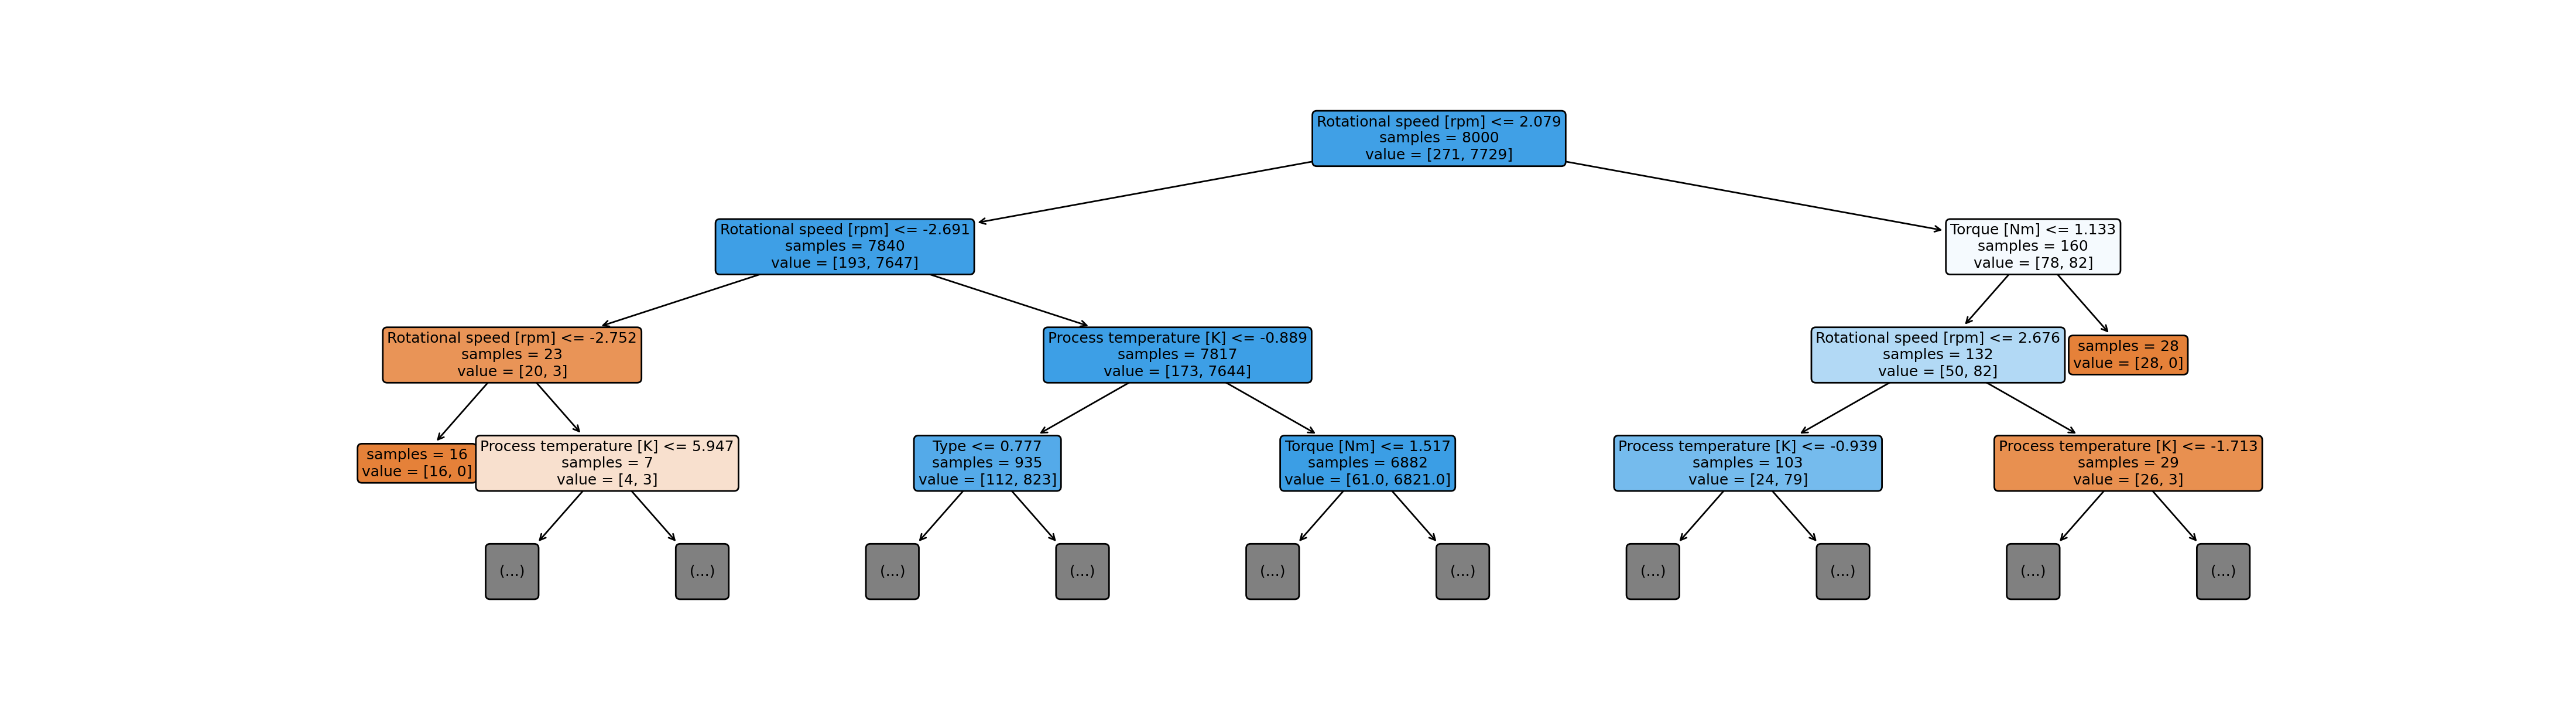

In [15]:
results['DT_Default'] = run_model(DecisionTreeClassifier(random_state=1), x_train, y_train, x_test, y_test, target_names, print_results=True)

plt.figure(figsize=(22, 6))
plot_tree(results['DT_Default']['learnt_model'], max_depth=3, feature_names=list(X.columns),
          fontsize=9, filled=True, impurity=False, rounded=True)
plt.show()

In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('dt', DecisionTreeClassifier(random_state=1))  # Decision Tree classifier
])

# Define the parameter grid to search for Decision Tree
param_grid = {
    'dt__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'dt__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'dt__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'dt__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Running the grid search with Decision Tree and evaluating its performance
results['DT_Optimized'] = run_cv_model(GridSearchCV, pipeline, param_grid,
                                                  x_train, y_train, x_test, y_test, target_names, print_results=True)

# plt.figure(figsize=(16, 8))
# plot_tree(results['DT_Optimized']['learnt_model'], max_depth=3, feature_names=list(X.columns),
#           fontsize=9, filled=True, impurity=False, rounded=True)
# plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Model: DecisionTreeClassifier
CV F1 Score: 0.692

Accuracy: 0.982
MCC: 0.726
F1 Score: 0.735
Precision: 0.735
Recall: 0.735

Training Time: 6.584s
Test Time: 0.000s
Max Memory Usage: 0.000MB

Best parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}
Best score: 0.692

Confusion Matrix:


,Predicted Fail,Predicted Pass
Actual Fail,50,18
Actual Pass,18,1914


## 11. Summarize results
* Output the accuracy, training time, test time, and memory usage of each model
* Note that with small datasets, default models may outperform optimized models
* This is because the optimized models split the training dataset further into internal training and validation datasets to optimize their hyper parameters

In [17]:
# Summarize results

data = []
for key, value in results.items():
    if value is not None:
        data.append({
            'Model': key,
            'F1 Score': value['f1'],
            'Precision': value['precision'],
            'Recall': value['recall'],
            'MCC': value['mcc'],
            'Accuracy': value['accuracy'],
            'CV F1 Score': value['cv_f1'],
            'Overkill': value['overkill'],
            'Escape': value['escape'],
            'Training Time': value['training_time'],
            'Test Time': value['test_time'],
            'Memory Usage': value['max_memory_usage']
        })

# Convert the data list to a DataFrame
results_df = pd.DataFrame(data).round(3)
sorted_df = results_df.sort_values(by='F1 Score', ascending=False)

display(sorted_df)

,Model,F1 Score,Precision,Recall,MCC,Accuracy,CV F1 Score,Overkill,Escape,Training Time,Test Time,Memory Usage
7,DT_Optimized,0.735,0.735,0.735,0.726,0.982,0.692,0.009,0.009,6.584,0.000,0.000
6,DT_Default,0.711,0.716,0.706,0.701,0.980,0.639,0.010,0.010,0.133,0.001,0.031
5,SVM_Optimized,0.608,0.912,0.456,0.637,0.980,0.608,0.002,0.018,9.954,0.043,12.391
3,KNN_Optimized,0.485,0.714,0.368,0.501,0.974,0.508,0.005,0.022,2.786,0.041,0.125
2,KNN_Default,0.468,0.846,0.324,0.514,0.975,0.432,0.002,0.023,0.113,0.036,0.000
4,SVM_Default,0.440,0.870,0.294,0.497,0.974,0.336,0.002,0.024,0.219,0.049,11.953
0,LR_Default,0.276,0.632,0.176,0.323,0.968,0.307,0.004,0.028,0.130,0.000,0.750
1,LR_Optimized,0.273,0.600,0.176,0.314,0.968,0.315,0.004,0.028,3.722,0.000,7.562


## 12. Visualize results
* Plot the F1 score in descending order

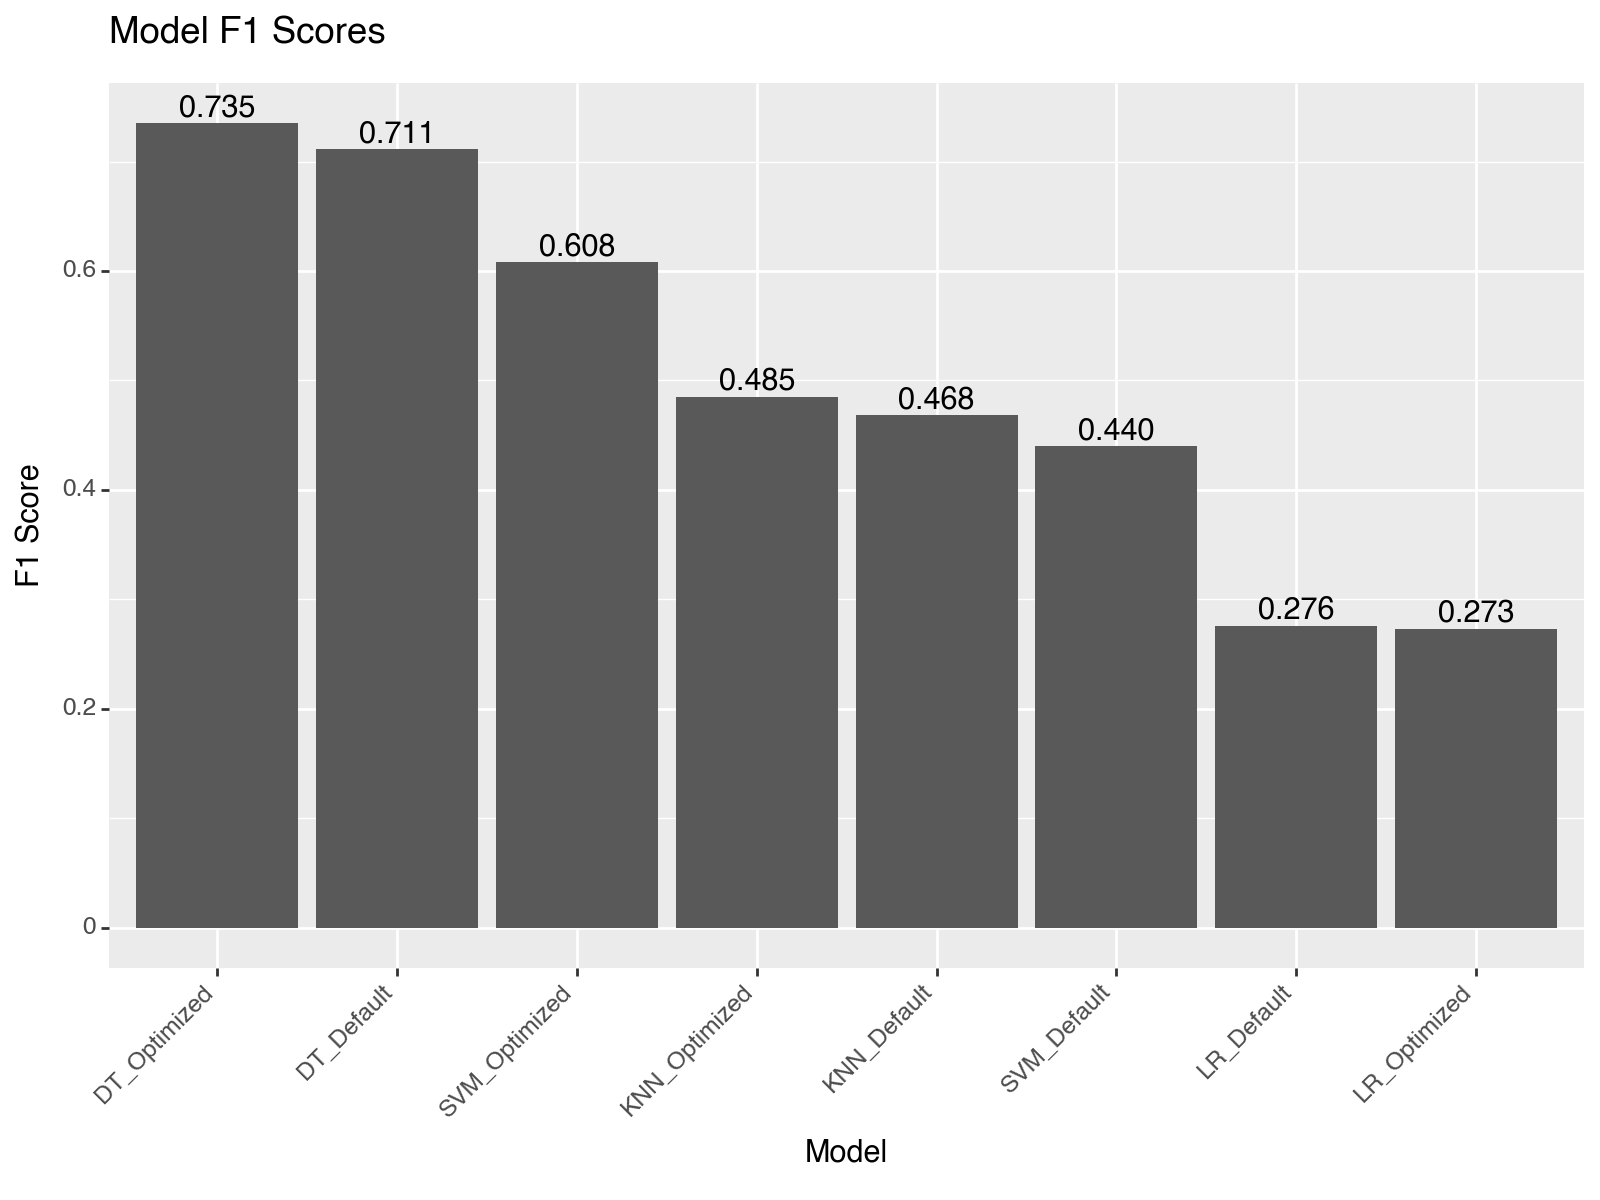

<Figure Size: (800 x 600)>

In [18]:
# Plot the F1 score

sorted_df['Model'] = pd.Categorical(sorted_df['Model'], categories=sorted_df['Model'])

accuracy_plot = (
    ggplot(sorted_df, aes(x='Model', y='F1 Score')) +
    geom_bar(stat='identity') +
    labs(title='Model F1 Scores', y='F1 Score', x='Model') +
    geom_text(aes(label='F1 Score'), stat='identity', position='stack', va='bottom', format_string='{:.3f}') +  # Format the labels to two decimal places
    theme(axis_text_x=element_text(rotation=45, ha='right'), figure_size=(8, 6))
)

# Display the accuracy plot
display(accuracy_plot)


In [19]:
# Original paper results

tp = 294
fp = 45
fn = 121
tn = 9540

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.87
Recall: 0.71
F1 Score: 0.78
